First 5 rows of the dataset:
   Unnamed: 0  count  hate_speech  offensive_language  neither  class  \
0           0      3            0                   0        3      2   
1           1      3            0                   3        0      1   
2           2      3            0                   3        0      1   
3           3      3            0                   2        1      1   
4           4      6            0                   6        0      1   

                                               tweet  
0  rt woman <neg> complain cleaning house amp man...  
1  rt boy dat coldtyga dwn bad cuffin dat hoe st ...  
2  rt dawg rt ever fuck bitch start cry confused ...  
3                                rt look like tranny  
4  rt shit hear might true might faker bitch told ya  

Checking for missing values:
Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 2
dtyp

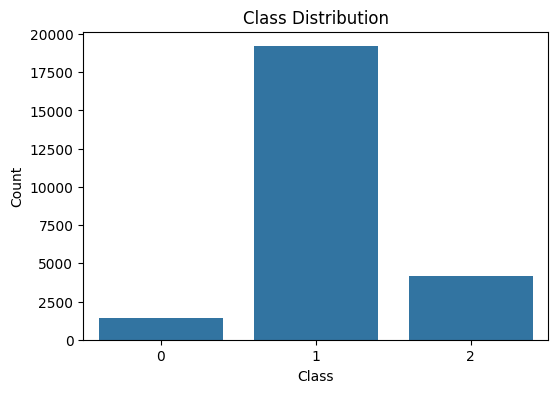


Encoded Labels Mapping:
0: 0
1: 1
2: 2

Training samples: 19824
Testing samples: 4957
Using device: cpu
RoBERTa Model loaded successfully.
BERT Model loaded successfully.

Ensemble Model Classification Report (Averaging Probabilities):
              precision    recall  f1-score   support

           0       0.56      0.47      0.51       286
           1       0.95      0.96      0.96      3838
           2       0.92      0.93      0.92       833

    accuracy                           0.93      4957
   macro avg       0.81      0.78      0.79      4957
weighted avg       0.92      0.93      0.92      4957



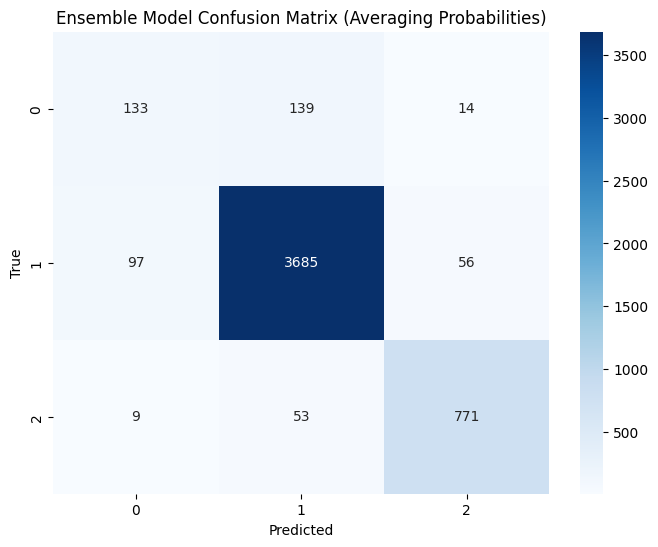


Ensemble Model Classification Report (Majority Voting):
              precision    recall  f1-score   support

           0       0.51      0.59      0.55       286
           1       0.95      0.95      0.95      3838
           2       0.94      0.87      0.91       833

    accuracy                           0.92      4957
   macro avg       0.80      0.81      0.80      4957
weighted avg       0.92      0.92      0.92      4957



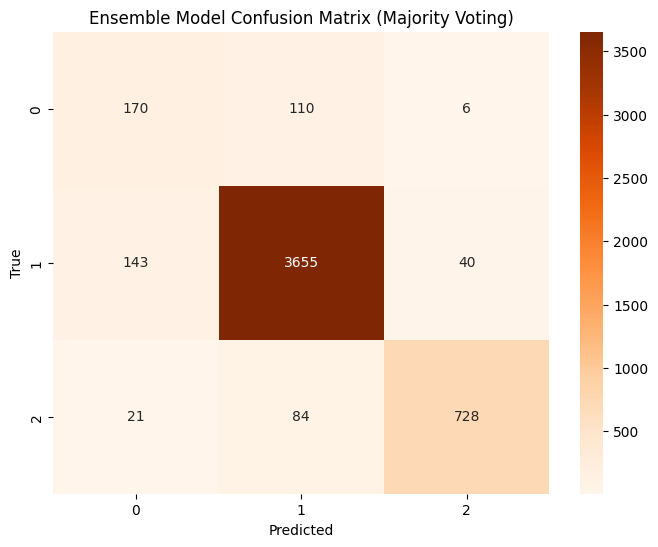

In [6]:
# ============================================
# 1. Import Necessary Libraries
# ============================================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from scipy.stats import mode
from sklearn.model_selection import train_test_split

# ============================================
# 2. Load and Preprocess the Dataset
# ============================================
# Path to your dataset
data_path = '/Users/tisyavaidya/Desktop/ABC.csv'  # Update this path if necessary

# Load the dataset
df = pd.read_csv(data_path)

# Display the first few rows
print("First 5 rows of the dataset:")
print(df.head())

# Check for missing values
print("\nChecking for missing values:")
print(df.isnull().sum())

# Drop rows with missing 'tweet' values
df = df.dropna(subset=['tweet']).reset_index(drop=True)

# Analyze Class Distribution
print("\nClass Distribution:")
print(df['class'].value_counts())

# Plot class distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# ============================================
# 3. Encode Labels
# ============================================
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['class'])

# Display encoded labels mapping
print("\nEncoded Labels Mapping:")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

# ============================================
# 4. Split the Data into Training and Testing Sets
# ============================================
# Split data to match the original setup
X = df['tweet'].values
y = encoded_labels

# Maintain the original train-test split logic (20% test set)
X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train_texts)}")
print(f"Testing samples: {len(X_test_texts)}")  # Should align with ~2,479 samples for comparison

# ============================================
# 5. Load Pretrained Models and Tokenizers
# ============================================
# Check if CUDA is available and set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# a. Load RoBERTa Tokenizer and Model
roberta_model_dir = '/Users/tisyavaidya/Desktop/RoBERTa_davidson2017_multiclass_Final'

roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta_model_dir)
roberta_model = RobertaForSequenceClassification.from_pretrained(roberta_model_dir)
roberta_model.to(device)
roberta_model.eval()
print("RoBERTa Model loaded successfully.")

# b. Load BERT Tokenizer and Model
bert_model_dir = '/Users/tisyavaidya/Desktop/Trained_Models/BERT_davidson2017_multiclass'

bert_tokenizer = BertTokenizer.from_pretrained(bert_model_dir)
bert_model = BertForSequenceClassification.from_pretrained(bert_model_dir)
bert_model.to(device)
bert_model.eval()
print("BERT Model loaded successfully.")

# ============================================
# 6. Define Preprocessing Function for Transformers
# ============================================
def preprocess_transformers(texts, tokenizer, max_length=100):
    return tokenizer.batch_encode_plus(
        texts,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

# ============================================
# 7. Generate Predictions from Each Model
# ============================================
def get_transformer_predictions(texts, tokenizer, model, device, max_length=100, batch_size=32):
    all_probs = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        encoded = preprocess_transformers(batch_texts, tokenizer, max_length)
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1).cpu().numpy()
            all_probs.append(probs)
    return np.vstack(all_probs)

# Generate RoBERTa predictions
roberta_probs = get_transformer_predictions(X_test_texts, roberta_tokenizer, roberta_model, device, max_length=100, batch_size=32)

# Generate BERT predictions
bert_probs = get_transformer_predictions(X_test_texts, bert_tokenizer, bert_model, device, max_length=100, batch_size=32)

# ============================================
# 8. Stack Predictions
# ============================================
# a. Averaging Probabilities
ensemble_probs = (roberta_probs + bert_probs) / 2
ensemble_pred_labels = np.argmax(ensemble_probs, axis=1)

# b. Majority Voting (Optional)
roberta_pred_classes = np.argmax(roberta_probs, axis=1)
bert_pred_classes = np.argmax(bert_probs, axis=1)

stacked_pred_classes = np.vstack([roberta_pred_classes, bert_pred_classes])
ensemble_pred_labels_mv, _ = mode(stacked_pred_classes, axis=0)
ensemble_pred_labels_mv = ensemble_pred_labels_mv.flatten()

# ============================================
# 9. Evaluate Ensemble Models
# ============================================
# a. Classification Report for Averaging Probabilities
print("\nEnsemble Model Classification Report (Averaging Probabilities):")
print(classification_report(y_test, ensemble_pred_labels, target_names=label_encoder.classes_.astype(str), zero_division=0))

# Confusion Matrix for Averaging Probabilities
conf_matrix = confusion_matrix(y_test, ensemble_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Model Confusion Matrix (Averaging Probabilities)')
plt.show()

# b. Classification Report for Majority Voting (Optional)
print("\nEnsemble Model Classification Report (Majority Voting):")
print(classification_report(y_test, ensemble_pred_labels_mv, target_names=label_encoder.classes_.astype(str), zero_division=0))

# Confusion Matrix for Majority Voting
conf_matrix_mv = confusion_matrix(y_test, ensemble_pred_labels_mv)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_mv, annot=True, fmt='d', cmap='Oranges',
            xticklabels=label_encoder.classes_.astype(str),
            yticklabels=label_encoder.classes_.astype(str))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Ensemble Model Confusion Matrix (Majority Voting)')
plt.show()
